# Análisis Detallado de los Datos de Yelp

### Importamos las librerías 

In [2]:
import pandas as pd
import numpy as np
import json # Para trabajar con JSON
from pandas import json_normalize
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
#from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Descargar los stopwords en español e inglés
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")
#plt.rcParams["figure.figsize"] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\JS
[nltk_data]     Digital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de Archivo business

In [37]:
data_business = pd.read_pickle('D:/2024/HenryData/PF/Datos_Crudos/yelp/business.pkl')

In [38]:
data_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Recorte del las columnas duplicadas
df_business = data_business.iloc[:, :14]

In [50]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [61]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150346 non-null  object
 13  hours         127123 non-null  object
dtypes: object(14)
memory usage: 17.2+ MB


### Análisis General: 
Con el objetivo de: Identificar las categorías más populares permite focalizar análisis en sectores clave.

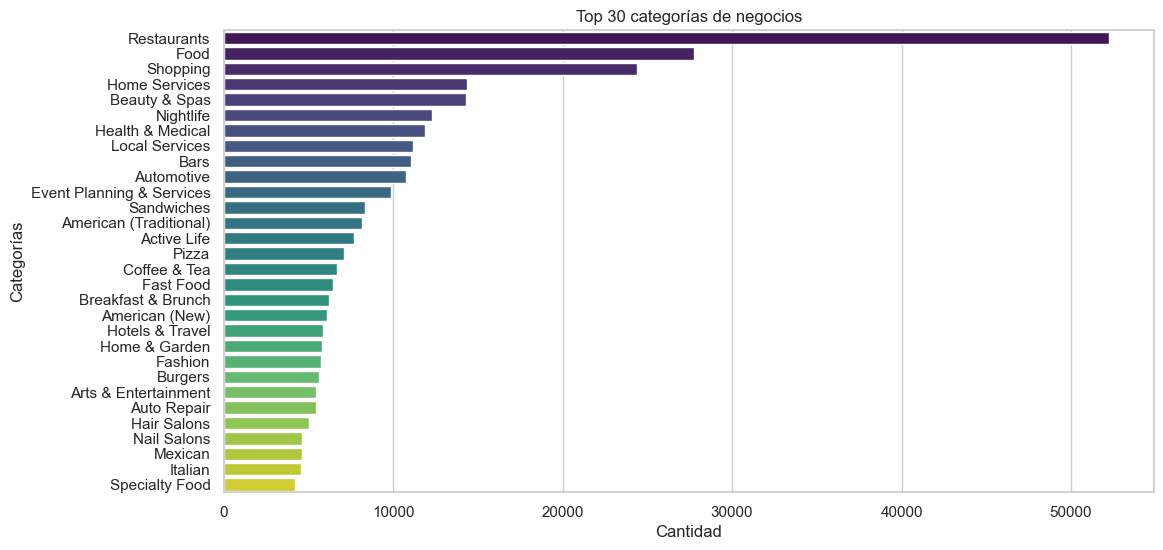

In [62]:
# Contar las categorías más comunes
df_business["categories"] = df_business["categories"].fillna("").apply(lambda x: x.split(", "))
categories = df_business["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=categories.values, y=categories.index, palette="viridis")
plt.title("Top 30 categorías de negocios")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

Conslusión:
La categoria que predomida en el df_business, es la relacionada a alimentación, restaurantes y comida, ocupando los dos primeros lugares, también se observan otras categorias relacionadas a la alimentación como son los sandwiches, pizza, comidad rápida, etc. En ese sentido nuestro análisis esta enfocado al análisis del sector alimentación específicamente nos enfocaremos en la categoría Restaurantes.


### Filtramos el dataframe business enfocando nuestro análisis al sector alimentación

In [66]:
# Realizamos un copy del Dataframe original
df_business1 = data_business.iloc[:, :14].copy()

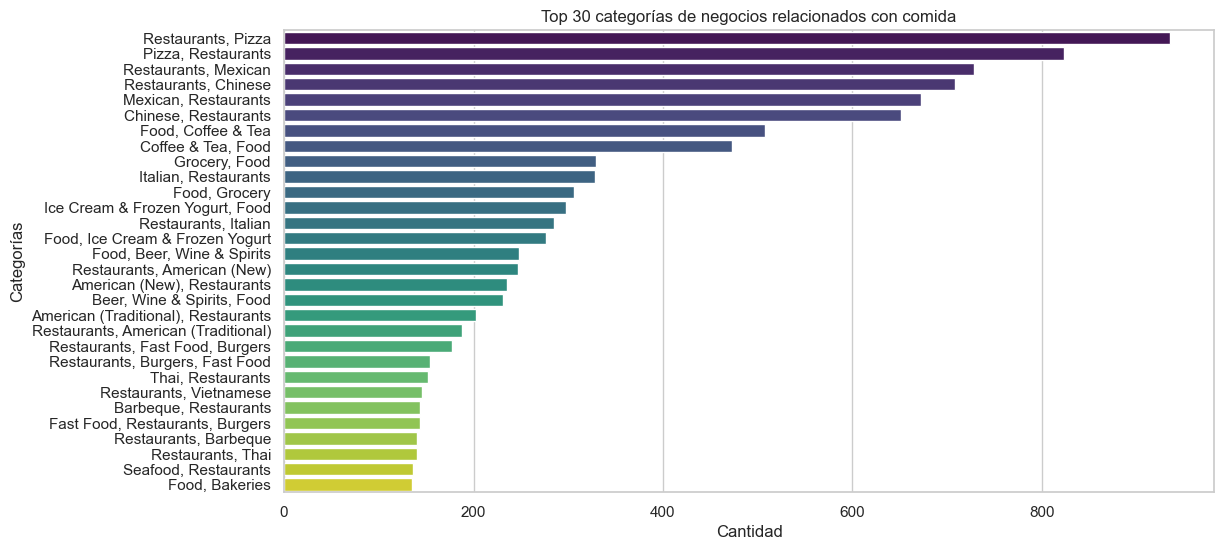

In [68]:
# Opción 1: Rellenar los valores nulos con una cadena vacía antes de aplicar la función
df_business1['categories'] = df_business1['categories'].fillna("")

# Opción 2: Filtrar los valores no nulos antes de aplicar la función (recomendado)
df_business_filtered = df_business1.dropna(subset=['categories'])  # Elimina filas con categorías nulas

# Crear la columna booleana para comida (utilizando el DataFrame filtrado)
df_business_filtered['is_food_related'] = df_business_filtered['categories'].apply(lambda x: any(word in x for word in ['Restaurants', 'Food', 'Pizza', 'Burgers', 'Sandwiches', 'Mexican', 'Italian', 'Chinese', 'Japanese', 'Thai', 'Indian', 'Coffee', 'Tea']))

# Filtrar los negocios relacionados con comida
df_food = df_business_filtered[df_business_filtered['is_food_related']]

# Contar las categorías más comunes de comida
categories_food = df_food["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes de comida
plt.figure(figsize=(12, 6))
sns.barplot(x=categories_food.values, y=categories_food.index, palette="viridis")
plt.title("Top 30 categorías de negocios relacionados con comida")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

Conclusión:
- El gráfico muestra que Restaurants Pizza o Pizza, Resturants predomica como una de las principales categorías; segudio de Restaurants, Mexican y muchas otras combinaciones más como italiana, asiática, etc. Esto refleja la multiculturalidad de la población estadounidense y su gusto por diferentes sabores.
- Además la crecinente demanda por comida latina, hace que nuestro análsis se enfoque en restaurantes que brindan alimentos de origen latino, para ello se segmentará aún más el dataset. 

### Análisis de restaurantes latinos

Construimos un diccionario con las palabras claves asociadas a los restaurantes de tipo latino

In [69]:
# Diccionario de palabras clave asociadas a cada tipo de restaurante latino
categoria_restaurante = {
    'restaurante argentino': ['argentine', 'argentinian', 'argentinian restaurant'],
    'restaurante mexicano': ['mexican', 'mexican restaurant', 'burrito', 'taco', 'pozole', 'Oaxacan'],
    'restaurante colombiano': ['colombian', 'colombian restaurant'],
    'restaurante peruano': ['peruvian', 'peruvian restaurant'],
    'restaurante brasileño': ['brazilian', 'brazilian restaurant'],
    'restaurante cubano': ['cuban', 'cuban restaurant'],
    'restaurante venezolano': ['venezuelan', 'venezuelan restaurant'],
    'restaurante chileno': ['chilean', 'chilean restaurant'],
    'restaurante ecuatoriano': ['ecuadorian', 'ecuadorian restaurant'],
    'restaurante dominicano': ['dominican', 'dominican restaurant'],
    'restaurante centroamericano': ['honduran', 'guatemalan', 'nicaraguan', 'panamanian', 'salvadoran', 'costarican', 'costa rican restaurant', 'honduran restaurant'],
    'restaurante caribeño': ['caribbean', 'caribbean restaurant'],
    'restaurante latinoamericano': ['latin american food', 'latin american', 'south american', 'latin', 'hispanic', 'south american restaurant'],
    'restaurante boliviano': ['bolivian', 'bolivian restaurant'],
    'restaurante paraguayo': ['paraguayan', 'paraguayan restaurant'],
    'restaurante uruguayo': ['uruguayan', 'uruguayan restaurant'],
    'restaurante puertorriqueño': ['puerto rican', 'puerto rican restaurant']
}

# Función para categorizar los restaurantes
def categorizar_restaurante(categoria):
    if isinstance(categoria, str):  # Verificar que la categoría es una cadena
        for categoria_nombre, keywords in categoria_restaurante.items():
            if any(keyword.lower() in categoria.lower() for keyword in keywords):
                return categoria_nombre
    return 'otros'  # Si no coincide con ninguna categoría o no es cadena, clasificar como 'otros'

In [70]:
# Aplicar la función a la columna 'categories' para crear una nueva columna 'restaurante_categoria'
df_food['restaurante_categoria'] = df_food['categories'].apply(categorizar_restaurante)

# Verificar las primeras filas con la nueva columna
print(df_food[['name', 'categories', 'restaurante_categoria']].head())

                       name  \
0  Abby Rappoport, LAC, CMQ   
3        St Honore Pastries   
4  Perkiomen Valley Brewery   
5            Sonic Drive-In   
8     Tsevi's Pub And Grill   

                                          categories restaurante_categoria  
0  Doctors, Traditional Chinese Medicine, Naturop...                 otros  
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...                 otros  
4                          Brewpubs, Breweries, Food                 otros  
5  Burgers, Fast Food, Sandwiches, Food, Ice Crea...                 otros  
8  Pubs, Restaurants, Italian, Bars, American (Tr...                 otros  


In [71]:
# Análisis detallado del DataFrame
# 1. Contar el número de restaurantes por categoría
conteo_categorias = df_food['restaurante_categoria'].value_counts()
print("\nConteo por categoría:")
print(conteo_categorias)


Conteo por categoría:
restaurante_categoria
otros                          59474
restaurante mexicano            4611
restaurante caribeño             471
restaurante cubano               256
restaurante latinoamericano      204
restaurante brasileño             84
restaurante peruano               69
restaurante colombiano            59
restaurante venezolano            39
restaurante centroamericano       38
restaurante argentino             34
restaurante dominicano            28
Name: count, dtype: int64


In [72]:

# 2. Filtrar solo los restaurantes latinos para análisis adicional
restaurantes_latinos = df_food[df_food['restaurante_categoria'] != 'otros']

In [73]:
restaurantes_latinos.shape

(5893, 16)

In [74]:
# 3. Mostrar las ciudades con más restaurantes latinos
ciudades_populares = restaurantes_latinos['city'].value_counts().head(10)
print("\nTop 10 ciudades con más restaurantes latinos:")
print(ciudades_populares)



Top 10 ciudades con más restaurantes latinos:
city
Tucson           544
Tampa            520
Philadelphia     491
Indianapolis     433
Nashville        331
Reno             201
New Orleans      192
Saint Louis      157
Santa Barbara    135
Boise            114
Name: count, dtype: int64


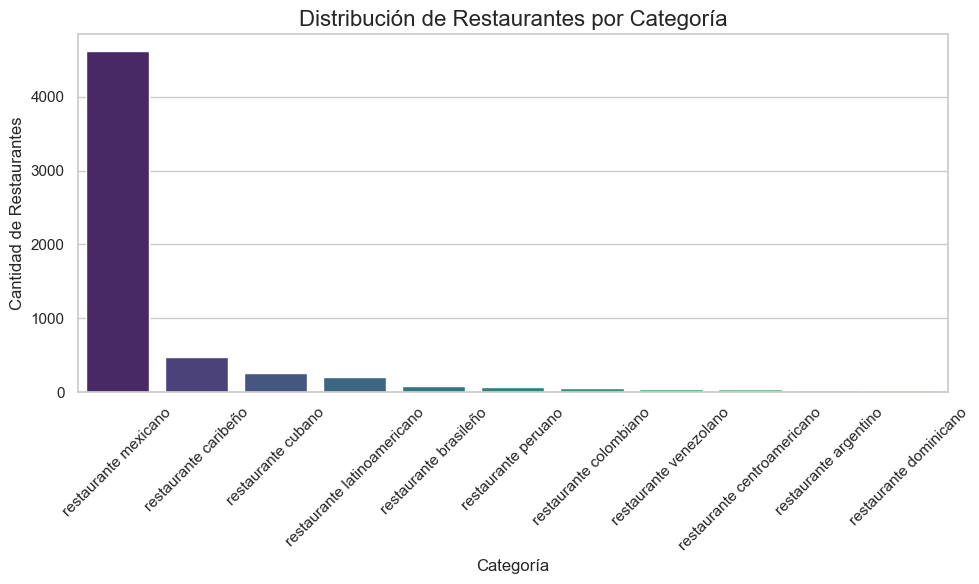

In [75]:
# 4. Graficar la distribución de restaurantes latinos por categoría
plt.figure(figsize=(10, 6))
sns.barplot(x=(restaurantes_latinos['restaurante_categoria'].value_counts()).index, y=(restaurantes_latinos['restaurante_categoria'].value_counts()).values, palette="viridis")
plt.title("Distribución de Restaurantes por Categoría", fontsize=16)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Cantidad de Restaurantes", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Promedio de estrellas por categoría:
restaurante_categoria
restaurante venezolano          4.24359
restaurante argentino          4.147059
restaurante centroamericano    4.131579
restaurante colombiano         4.067797
restaurante peruano            4.036232
restaurante cubano             3.972656
restaurante dominicano         3.964286
restaurante brasileño          3.946429
restaurante latinoamericano    3.865196
restaurante caribeño           3.834395
restaurante mexicano           3.516049
Name: stars, dtype: object


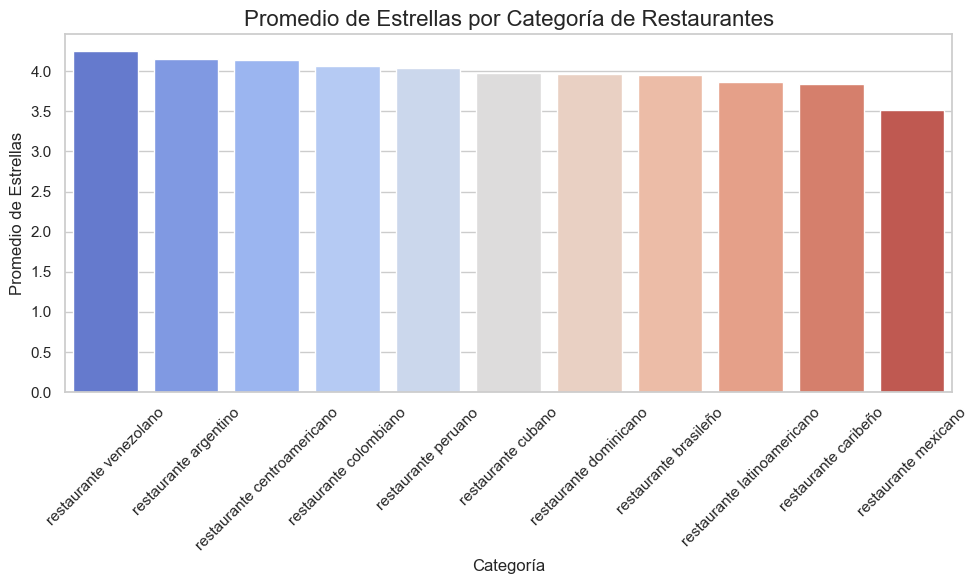

In [76]:
# 5. Analizar la relación entre estrellas y categorías
categoria_estrellas = restaurantes_latinos.groupby('restaurante_categoria')['stars'].mean().sort_values(ascending=False)
print("\nPromedio de estrellas por categoría:")
print(categoria_estrellas)
# Graficar la relación
plt.figure(figsize=(10, 6))
sns.barplot(x=categoria_estrellas.index, y=categoria_estrellas.values, palette="coolwarm")
plt.title("Promedio de Estrellas por Categoría de Restaurantes", fontsize=16)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Promedio de Estrellas", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
df_restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",None
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',..."


In [82]:
df_restaurantes_latinos['city'].unique()

array(['Wilmington', 'Largo', 'Nashville', 'New Orleans', 'Hermitage',
       'Odessa', 'Horsham', 'Brownsburg', 'Isla Vista', 'Tampa',
       'Saint Louis', 'Goleta', 'St. Louis', 'Tucson', 'Saint Charles',
       'Saint Petersburg', 'Sparks', 'Madeira Beach', 'Media', 'Edmonton',
       'Port Richey', 'Sicklerville', 'Indianapolis', 'Zionsville',
       'Seminole', 'Boise', 'Springfield', 'East Norriton', 'Lansdale',
       'Old Hickory', 'Palm Harbor', 'Pitman', 'Reno', 'Philadelphia',
       'Pinellas Park', 'Avon', 'Brentwood', 'Cahokia', 'West Chester',
       'Clearwater', "Land O' Lakes", 'Metairie', 'Santa Barbara',
       'Holiday', 'Prospect Park', 'Lebanon', 'Chalfont', 'Camden',
       'Clearwater Beach', 'King of Prussia', 'Plainfield', 'Seffner',
       'Gulfport', 'Alton', 'Cherry Hill', 'Valrico', 'Collinsville',
       'Meridian', 'Fishers', 'Gilbertsville', 'Garden City', 'Marlton',
       'ST. Louis', 'Sherwood Park', 'New Hope', 'Bordentown', 'Smyrna',
       'Clem

Asignar estado

In [91]:
# Diccionario inicial de ciudades y sus estados (algunos ejemplos comunes)
ciudades_estados = {
    'DE': ['Wilmington'],
    'FL': ['Largo', 'Tampa', 'Clearwater', 'St. Petersburg', "Land O' Lakes", 'Tampa Bay',
           'Hudson', 'Pinellas Park', 'Wesley Chapel'],
    'TN': ['Nashville', 'Ashland City', 'Brentwood', 'White House'],
    'LA': ['New Orleans', 'Metairie', 'Kenner', 'Harvey'],
    'MO': ['Saint Louis', 'St. Louis', 'Springfield', 'Affton'],
    'CA': ['Goleta', 'Santa Barbara'],
    'AZ': ['Tucson'],
    'NV': ['Reno', 'Sparks', 'Fernley'],
    'PA': ['Philadelphia', 'Newtown', 'Green Lane', 'Paoli', 'Ardmore', 'Exton', 'Bala Cynwyd',
           'Plymouth Meeting', 'West Chester', 'Glenolden', 'Bensalem'],
    'IN': ['Indianapolis', 'Carmel', 'Fishers'],
    'NJ': ['Cherry Hill', 'Williamstown', 'Camden', 'Maplewood'],
    'IL': ['Edwardsville', 'Alton', 'Plainfield', 'Belleville'],
    'VT': ['Burlington'],
    'NY': ['Troy'],
    'MS': ['Meridian'],
    'ID': ['Boise'],
    'AB': ['Edmonton'],  # Canadá (podrías excluir si no son relevantes)
}

In [92]:
def asignar_estado(ciudad, diccionario_ciudades):
  """Devuelve la abreviatura del estado según la ciudad."""
  return diccionario_ciudades.get(ciudad, "Desconocido")  # Devuelve "Desconocido" si la ciudad no está en el diccionario

In [93]:
# Aplicar la función al DataFrame
df_restaurantes_latinos['state1'] = df_restaurantes_latinos['city'].apply(lambda x: asignar_estado(x, ciudades_estados))  # Usa la variable correcta "ciudades_estados"

In [94]:
# Verificar los resultados
print(df_restaurantes_latinos[['city', 'state', 'state1']].head(10))

            city state       state1
104   Wilmington    IN  Desconocido
153        Largo    IN  Desconocido
159    Nashville    ID  Desconocido
278  New Orleans    FL  Desconocido
290    Hermitage    FL  Desconocido
345       Odessa    FL  Desconocido
348      Horsham    FL  Desconocido
351   Brownsburg    PA  Desconocido
401   Isla Vista    IN  Desconocido
408        Tampa    LA  Desconocido


In [97]:
# Identificar y mostrar las ciudades sin estado asignado
ciudades_sin_estado = df_restaurantes_latinos[df_restaurantes_latinos['state1'] == "Desconocido"]['city'].unique()
print(f"Total de ciudades sin estado asignado: {len(ciudades_sin_estado)}")
print(ciudades_sin_estado[:20])  # Mostrar las primeras 20

Total de ciudades sin estado asignado: 428
['Wilmington' 'Largo' 'Nashville' 'New Orleans' 'Hermitage' 'Odessa'
 'Horsham' 'Brownsburg' 'Isla Vista' 'Tampa' 'Saint Louis' 'Goleta'
 'St. Louis' 'Tucson' 'Saint Charles' 'Saint Petersburg' 'Sparks'
 'Madeira Beach' 'Media' 'Edmonton']


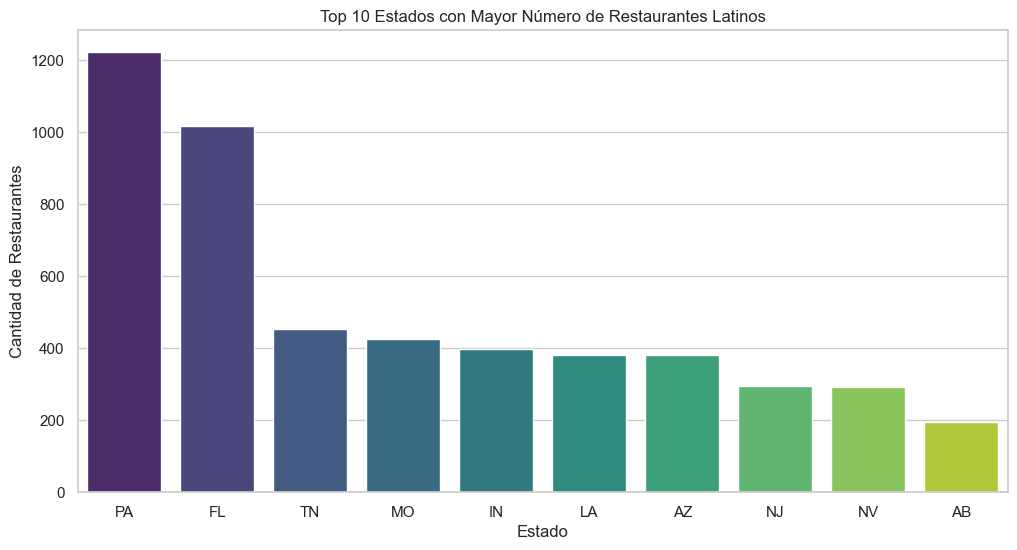

In [10]:

# Contar restaurantes por estado
restaurantes_por_estado = df_restaurantes_latinos['state'].value_counts().reset_index()
restaurantes_por_estado.columns = ['state', 'count']

# Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(data=restaurantes_por_estado.head(10), x='state', y='count', palette='viridis')
plt.title("Top 10 Estados con Mayor Número de Restaurantes Latinos")
plt.xlabel("Estado")
plt.ylabel("Cantidad de Restaurantes")
plt.show()

In [ ]:
#df_restaurantes_latinos.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/restaurantes_latinos.csv', index=False)
#D:\2024\HenryData\PF\Datos_Crudos\yelp